In [297]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from tqdm.auto import tqdm
from collections import defaultdict
from qiskit import QuantumCircuit
from qiskit.quantum_info import Clifford, Pauli, StabilizerState, random_pauli
import jax
from qiskit.circuit.library import RXGate, RYGate, RZGate

import pickle

In [656]:
class LocalVQA:
    def __init__(self, num_qubits, num_layers):
        assert num_qubits % 2 == 0
        self.num_qubits = num_qubits
        self.num_layers = num_layers
    
    @property
    def num_parameters(self):
        return 2 * self.num_qubits * (self.num_layers + 1)
    
    def initial_gates(self, x, z):
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def entangling_layer(self, x, z, start=0):
        for n in range(start, self.num_qubits+start, 2):
            i = n % self.num_qubits
            j = (n +1 ) % self.num_qubits
            qml.CZ(wires=(i, j))
        
        for n in range(self.num_qubits):
            qml.RX(x[n], wires=n)
            qml.RZ(z[n], wires=n)
    
    def all_entangling_layers(self, x, z):
        s = 0
        for xi, zi in zip(x.reshape(self.num_layers, self.num_qubits), z.reshape(self.num_layers, self.num_qubits)):
            self.entangling_layer(xi, zi, start=s)
            s = 1-s
    
    def split_params(self, params):
        n = self.num_qubits
        x0 = params[:n]
        z0 = params[n: 2*n]
        
        num_x = len(params[2*n:]) // 2
        x = params[2*n: 2*n + num_x]
        z = params[2*n + num_x:]
        
        return x0, z0, x, z
        
    def circuit(self, params):
        x0, z0, x, z = self.split_params(params) 
        self.initial_gates(x0, z0)
        self.all_entangling_layers(x, z)
    
    def expval(self, pauli_string, params, interface=None):
        if isinstance(pauli_string, list):
            pauli_strings = pauli_string
        else:
            pauli_strings = [pauli_string]
            
        observables = [qml.pauli.string_to_pauli_word(ps) for ps in pauli_strings]
        dev = qml.device('default.qubit', wires=self.num_qubits)
        @qml.qnode(dev, interface=interface)
        def expectation():
            self.circuit(params)
            return [qml.expval(obs) for obs in observables]
        
        if isinstance(pauli_string, list):
            return np.asarray(expectation())
        else:
            return expectation()[0]
    
    def grad_expval(self, pauli_strings, k, params):
        ek = np.zeros_like(params)
        ek[k] = 1
        
        f = lambda p: self.expval(pauli_strings, params + np.pi / 2 * p)
        return (f(ek) - f(-ek)) / 2
                
    def hess_expval(self, pauli_strings, k, l, params):
        ek = np.zeros_like(params)
        el = np.zeros_like(params)
        ek[k] = 1
        el[l] = 1
        
        f = lambda p: self.expval(pauli_strings, params + np.pi / 2 * p)
        return (f(ek+el) - f(ek-el) - f(el-ek) + f(-ek-el)) / 4
            
    def random_parameters(self):
        return 2 * np.pi * np.random.uniform(size=self.num_parameters)
    
    def random_clifford_parameters(self):
        return np.pi / 2 * np.random.choice(range(4), size=self.num_parameters, replace=True) 
        
    def good_random_clifford_parameters(self, pauli_string):
        _, _, x, z = self.split_params(self.random_clifford_parameters())
        
        dev = qml.device('qiskit.aer', wires=range(self.num_qubits))
        @qml.qnode(dev)
        def circ(x, z):
            self.all_entangling_layers(x, z)
            return qml.expval(qml.Identity(wires=range(self.num_qubits)))
        
        circ(x, z)
        qc = dev._circuit
        qc.remove_final_measurements()
        
        entangled_pauli_string = Pauli(pauli_string[::-1]).evolve(Clifford(qc)).to_label()
 
        x0 = []
        z0 = []
        for p in entangled_pauli_string[::-1]:
            if p == 'I' or p == 'Z':
                x0.append(0)
                z0.append(0)
            if p == 'Y':
                x0.append(np.pi/2)
                z0.append(0)
            elif p == 'X':
                x0.append(np.pi/2)
                z0.append(np.pi/2)
        
        good_params = np.concatenate([x0, z0, x, z]) 
        assert np.allclose(np.abs(self.expval(pauli_string, good_params)), 1, atol=1e-5, rtol=1e-5)
        return good_params
    
    def draw(self):
        qml.draw_mpl(self.circuit)(*self.random_parameters())
        
def random_two_body_pauli(num_qubits):
    p1, p2 = np.random.choice(['X', 'Y', 'Z'], size=2, replace=True)
    i = np.random.choice(range(num_qubits-1))
    return 'I'*i + p1 + p2 + 'I'*(num_qubits-i-2)

In [3]:
def test_grads(num_qubits, num_layers):
    vqa = LocalVQA(num_qubits, num_layers)
    obs = random_two_body_pauli(vqa.num_qubits)
    
    p0 = vqa.random_clifford_parameters()
    f = lambda params: vqa.expval(obs, params, interface='jax')
    
    jax_grads = jax.grad(f)(p0)
    shift_grads = [vqa.grad_expval(obs, k, p0) for k in range(vqa.num_parameters)]
    
    jax_hess = jax.hessian(f)(p0)
    shift_hess = [[vqa.hess_expval(obs, k, l, p0) for k in range(vqa.num_parameters)] for l in range(vqa.num_parameters)]
    
    assert np.allclose(jax_grads, shift_grads, atol=1e-5, rtol=1e-5)
    assert np.allclose(jax_hess, shift_hess, atol=1e-5, rtol=1e-5)
    
    print('passed')

np.random.seed(0)
# test_grads(4, 2)

In [87]:
class Experiment:
    def __init__(self, name):
        self.name = name
        self.results = defaultdict(dict)
        self.barren_results = defaultdict(dict)
    
    def run_barren_plateau_experiment(self, num_qubits, layers, num_points, num_samples=None):
        
        if num_samples is None:
            num_samples = 200 * 2**num_qubits
    
        for num_layers in tqdm(layers):
            vqa = LocalVQA(num_qubits, num_layers)
            
            vals = []
            grads = []
            hess = []
            for _ in range(num_points):
                phi = vqa.random_clifford_parameters()
                observables = [random_two_body_pauli(vqa.num_qubits) for _ in range(num_samples // num_points)]
                
                vals.append(vqa.expval(observables, phi))
          
            self.barren_results[num_qubits][int(num_layers)] = {'vals': vals}  
        
        self.save()

    
    def run(self, num_qubits, layers, num_obs=10, num_samples=None):
        
        if num_samples is None:
            num_samples = 100 * 2**num_qubits
    
        for num_layers in tqdm(layers):
            vqa = LocalVQA(num_qubits, num_layers)
            
            vals = []
            grads = []
            hess = []
            for _ in range(num_obs):
                obs0 = random_two_body_pauli(vqa.num_qubits)
                phi0 = vqa.good_random_clifford_parameters(obs0)
                k = np.random.choice(range(vqa.num_parameters)) # random grad component
                l, m = np.random.choice(range(vqa.num_parameters), size=2) # random hessian component
                
                observables = [random_two_body_pauli(vqa.num_qubits) for _ in range(num_samples // num_obs)]
                
                vals.append(vqa.expval(observables, phi0))
                # grads.append(vqa.grad_expval(observables, k, phi0))
                # hess.append(vqa.hess_expval(observables, l, m, phi0))
          
            self.results[num_qubits][int(num_layers)] = {'vals': vals, 'grads': grads, 'hess': hess}  
        
        self.save()
        
    def plot_results(self, bp=False):
        if bp:
            expvals = self.barren_results
        else:
            expvals = self.results
        for n in expvals.keys():
            layers = list(expvals[n].keys())
            
            val_means = [np.abs(expvals[n][layer]['vals']).mean() for layer in layers] 
            # grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
            # hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]
            
            plt.scatter(layers, val_means)
            # plt.scatter(layers, grad_means, c='b')
            # plt.scatter(layers, hess_means, c='r')
    
    def save(self):
        with open(f'{self.name}', 'wb') as f:
            pickle.dump(self.results, f)
            
    @staticmethod
    def load(name):
        with open(name, 'rb') as f:
            results = pickle.load(f)
            exp = Experiment(name)
            exp.results = results
            return exp

In [657]:
def to_qiskit_circ(penny_circ, params, num_qubits):
    
    dev = qml.device('qiskit.aer', wires=range(num_qubits))
    @qml.qnode(dev)
    def circ(params):
        penny_circ(*params)
        return qml.expval(qml.Identity(wires=range(num_qubits)))
    
    circ(params)
    qc = dev._circuit
    qc.remove_final_measurements()
    return qc

In [623]:
gates = [RXGate, RYGate, RZGate]
def random_qc(num_layers):
    qc = QuantumCircuit(2)
    for _ in range(num_layers):
        qc.cz(0, 1)
        gate0, gate1 = np.random.choice(gates, size=2, replace=True)
        p0, p1 = np.pi/2 * np.random.choice(range(4), size=2, replace=True)
        qc.append(gate0(p0), [0])
        qc.append(gate1(p1), [1])
    return qc

In [416]:
# num_qubits = 6
# num_layers = 16
# np.random.seed(2)

# vqa = LocalVQA(num_qubits, num_layers)

In [645]:

psi0 = StabilizerState(QuantumCircuit(num_qubits))

# obs0 = random_two_body_pauli(num_qubits)
# p0 = vqa.good_random_clifford_parameters(obs0)

p0 = vqa.random_clifford_parameters()
qc = to_qiskit_circ(vqa.circuit, [p0], num_qubits)
# x0, z0, x, z = vqa.split_params(p0)
# 
# qc0 = to_qiskit_circ(vqa.initial_gates, [x0, z0], vqa.num_qubits)
# qc = to_qiskit_circ(vqa.all_entangling_layers, [x, z], vqa.num_qubits)
# 
# C0 = Clifford(qc0)
# C = Clifford(qc)

In [658]:
num_qubits = 6
num_layers = 16
num_points = 100
num_obs = 100 * 2**num_qubits

vqa = LocalVQA(num_qubits, num_layers)
np.random.seed(0)


values = []

for _ in tqdm(range(num_points)):
    p0 = vqa.random_clifford_parameters()
    observables = [random_two_body_pauli(vqa.num_qubits) for _ in range(num_obs)]
    values.append(vqa.expval(observables, p0))

  0%|          | 0/100 [00:00<?, ?it/s]

0.018468750000000082 0.015625


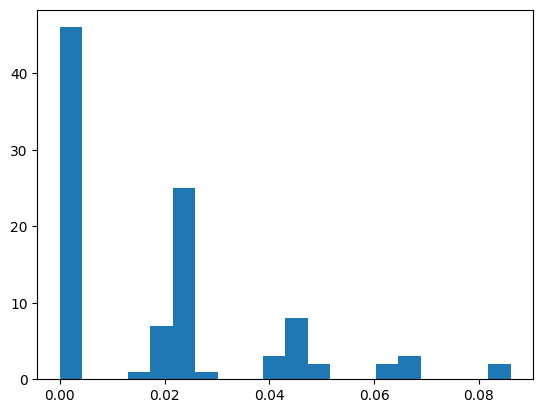

In [659]:
means = np.abs(values).mean(axis=1)
print(means.mean(), 2**-num_qubits)
plt.hist(means, bins=20);
# np.abs(values).mean(1)

0.060156250000000105 0.0625


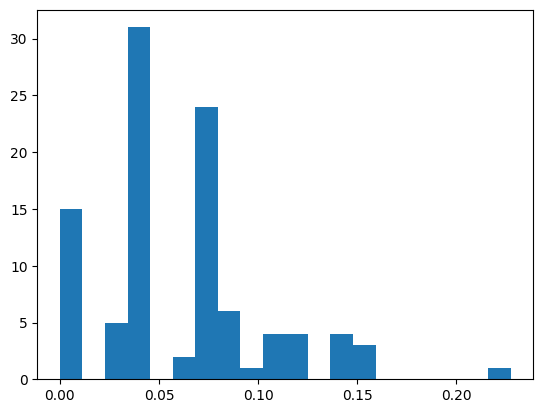

In [655]:
means = np.abs(values).mean(axis=1)
print(means.mean(), 2**-num_qubits)
plt.hist(means, bins=20);
# np.abs(values).mean(1)

In [617]:
num_observables = 10000
observables = [random_two_body_pauli(vqa.num_qubits) for _ in range(num_observables)]
observables_nonlocal = [random_pauli(num_qubits) for _ in range(num_observables)]

In [618]:
vals_nonlocal = np.array([psi0.expectation_value(Pauli(obs).evolve(C).evolve(C0)) for obs in observables_nonlocal])
np.abs(vals_nonlocal).mean(), 2**-num_qubits

(0.2403, 0.25)

In [619]:
vals = np.array([psi0.expectation_value(Pauli(obs).evolve(C)) for obs in observables])
np.abs(vals).mean(), 2**-num_qubits

(0.1087, 0.25)

In [621]:
all_vals = []

for _ in tqdm(range(20)):
    # p0 = vqa.random_clifford_parameters()
    # x0, z0, x, z = vqa.split_params(p0)
    # 
    # qc = to_qiskit_circ(vqa.all_entangling_layers, [x, z], vqa.num_qubits)
    # C = Clifford(qc)
    C = Clifford(random_qc(num_layers))
    vals = np.array([psi0.expectation_value(Pauli(obs).evolve(C)) for obs in observables])
    all_vals.append(vals)
    
all_vals = np.array(np.abs(all_vals))


  0%|          | 0/20 [00:00<?, ?it/s]

Averages over clifford points != averages over observables

qiskit random pauli (which allow 'I's) and weight 2 random Paulis (don't have 'I') behave differently. 

In [622]:
all_vals.mean(axis=1), all_vals.mean()

(array([0.3306, 0.1176, 0.3279, 0.1087, 0.1091, 0.1093, 0.3279, 0.1087,
        0.3419, 0.3279, 0.1091, 0.3336, 0.1122, 0.1118, 0.107 , 0.1087,
        0.1118, 0.1087, 0.3336, 0.1122]),
 0.187915)

In [231]:
bug = Experiment('bug')

In [251]:
np.random.seed(0)
num_qubits = 6
num_points = 100
num_samples = 100 * num_points * 2**num_qubits
num_layers = 50
bug.run_barren_plateau_experiment(num_qubits, [num_layers], num_points=num_points, num_samples=num_samples)

  0%|          | 0/1 [00:00<?, ?it/s]

In [252]:
np.asarray(np.abs(bug.barren_results[num_qubits][num_layers]['vals'])).mean(), 2**-num_qubits

(0.016085937500000168, 0.015625)

In [160]:
exp_test = Experiment('test')

In [180]:
np.random.seed(0)
num_qubits = 4
num_obs = 20
exp_test.run(num_qubits, layers=range(400, 600, 30), num_obs=num_obs)

  0%|          | 0/7 [00:00<?, ?it/s]

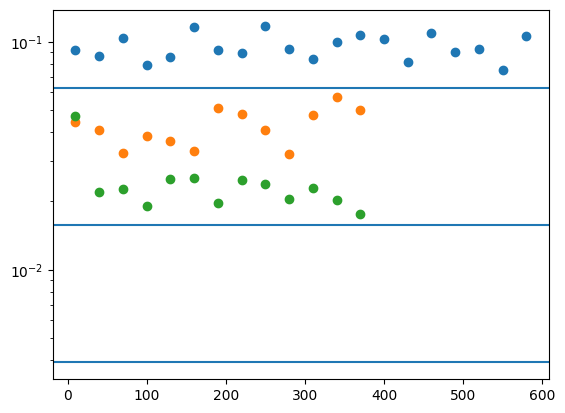

In [181]:
exp_test.plot_results()
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-8)
plt.yscale('log')

In [182]:
np.random.seed(0)
num_qubits = 6
num_obs = 20
exp_test.run(num_qubits, layers=range(400, 600, 30), num_obs=num_obs)

  0%|          | 0/7 [00:00<?, ?it/s]

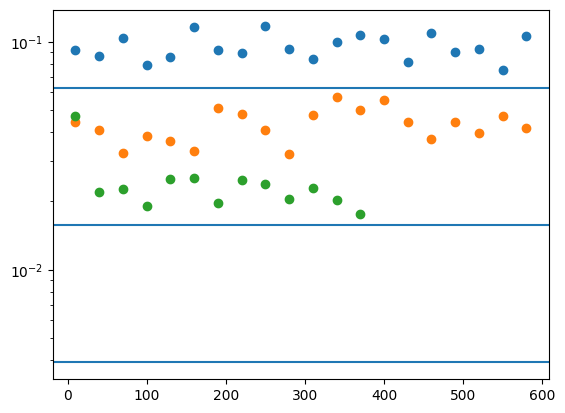

In [183]:
exp_test.plot_results()
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-8)
plt.yscale('log')

In [184]:
np.random.seed(0)
num_qubits = 8
num_obs = 20
exp_test.run(num_qubits, layers=range(400, 600, 30), num_obs=num_obs)

  0%|          | 0/7 [00:00<?, ?it/s]

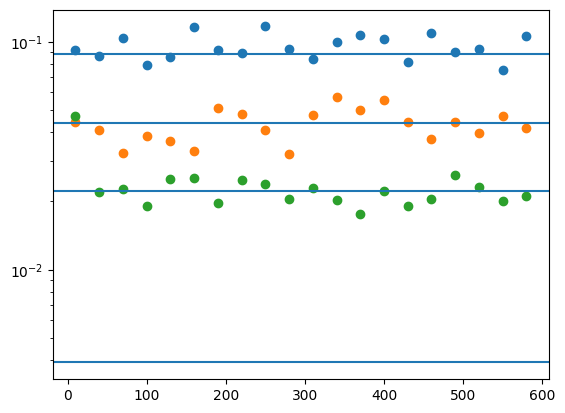

In [189]:
exp_test.plot_results()
plt.axhline(2**-3.5)
plt.axhline(2**-4.5)
plt.axhline(2**-5.5)
plt.axhline(2**-8)
plt.yscale('log')

In [190]:
np.random.seed(0)
num_qubits = 10
num_obs = 20
exp_test.run(num_qubits, layers=range(10, 600, 30), num_obs=num_obs)

  0%|          | 0/20 [00:00<?, ?it/s]

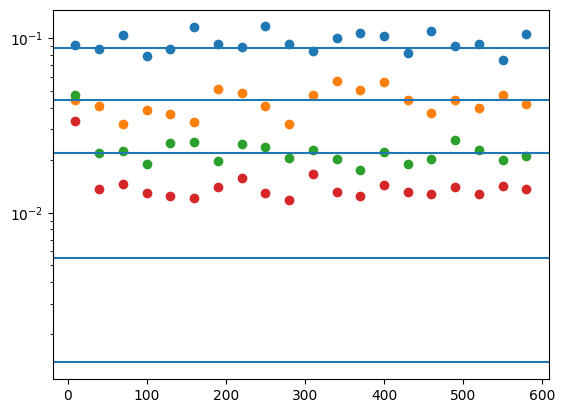

In [193]:
exp_test.plot_results()
plt.axhline(2**-3.5)
plt.axhline(2**-4.5)
plt.axhline(2**-5.5)
plt.axhline(2**-7.5)
plt.axhline(2**-9.5)

plt.yscale('log')

In [221]:
np.random.seed(0)
num_qubits = 12
num_obs = 20
exp_test.run(num_qubits, layers=range(10, 600, 30), num_obs=num_obs)

  0%|          | 0/20 [00:00<?, ?it/s]

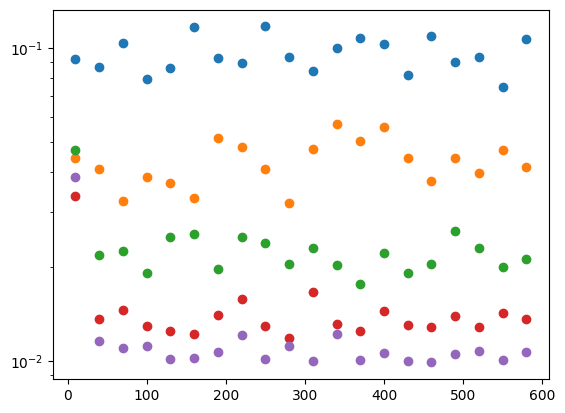

In [224]:
exp_test.plot_results()
plt.yscale('log')

In [222]:
np.random.seed(0)
num_qubits = 14
num_obs = 20
exp_test.run(num_qubits, layers=range(10, 600, 30), num_obs=num_obs)

  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt



In [677]:
aggregate_means = []
res = exp_test.results
for n in res.keys():
    vals = []
    for layer in res[n].keys():
        vals.append(res[n][layer]['vals'])
    aggregate_means.append(np.abs(np.array(vals))[-5:].mean())

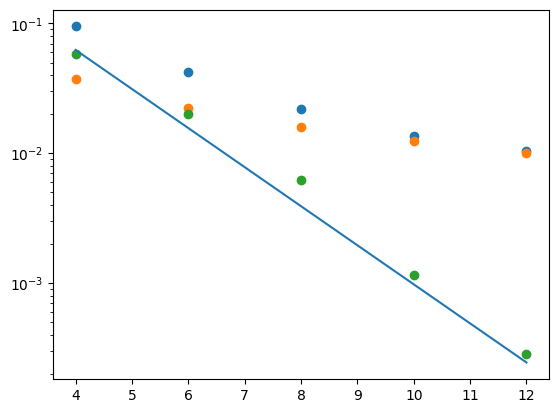

In [680]:
x = np.asarray(list(res.keys()))
y = aggregate_means

plt.scatter(res.keys(), aggregate_means)
plt.scatter(x, 1/(x-1) / 9)

plt.scatter(x, y - 1/(x-1) / 9)
plt.plot(x, 2.**-x)

plt.yscale('log')

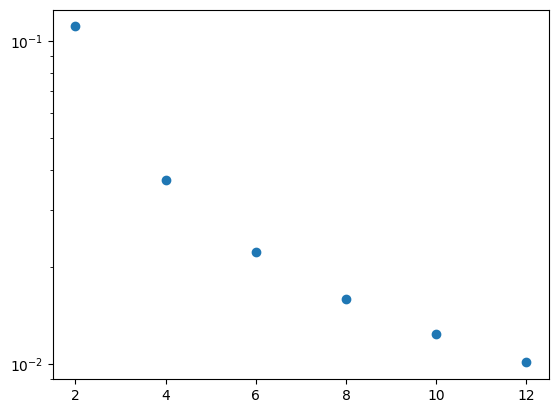

In [665]:

plt.yscale('log')

In [198]:
ns = exp_test.results.keys()
[it for it in exp_test.results[4].items()]

[(10,
  {'vals': [array([ 1.38777878e-16,  5.55111512e-17,  3.05311332e-16,  3.05311332e-16,
           -2.22044605e-16,  3.05311332e-16, -1.66533454e-16,  5.55111512e-17,
            0.00000000e+00, -2.22044605e-16,  1.38777878e-16, -1.66533454e-16,
            8.32667268e-17, -1.00000000e+00, -2.77555756e-17, -1.00000000e+00,
            0.00000000e+00,  2.77555756e-17, -1.66533454e-16, -2.49800181e-16,
            0.00000000e+00, -2.22044605e-16, -2.49800181e-16,  4.16333634e-16,
            0.00000000e+00, -1.00000000e+00, -2.77555756e-16,  5.55111512e-17,
            0.00000000e+00,  1.38777878e-16,  4.16333634e-16, -8.32667268e-17,
            8.32667268e-17,  4.16333634e-16, -2.77555756e-17,  4.16333634e-16,
            4.71844785e-16, -2.77555756e-16,  1.38777878e-16,  8.32667268e-17,
            1.38777878e-16, -1.66533454e-16,  3.05311332e-16,  0.00000000e+00,
           -2.77555756e-17, -2.22044605e-16,  2.77555756e-17, -2.77555756e-16,
           -1.66533454e-16,  8.3266726

In [89]:
exp = Experiment('test_bp')

In [155]:
np.random.seed(0)
num_qubits = 4
num_samples = 100 * 2**num_qubits
exp.run_barren_plateau_experiment(num_qubits, range(10, 200, 30), num_points=20, num_samples=num_samples)

  0%|          | 0/7 [00:00<?, ?it/s]

In [156]:
np.random.seed(0)
num_qubits = 6
num_samples = 100 * 2**num_qubits
exp.run_barren_plateau_experiment(num_qubits, range(10, 200, 30), num_points=20, num_samples=num_samples)

  0%|          | 0/7 [00:00<?, ?it/s]

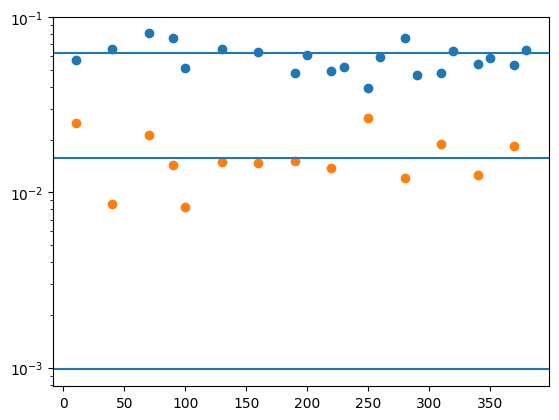

In [158]:
exp.plot_results(bp=True)
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-10)

plt.yscale('log')

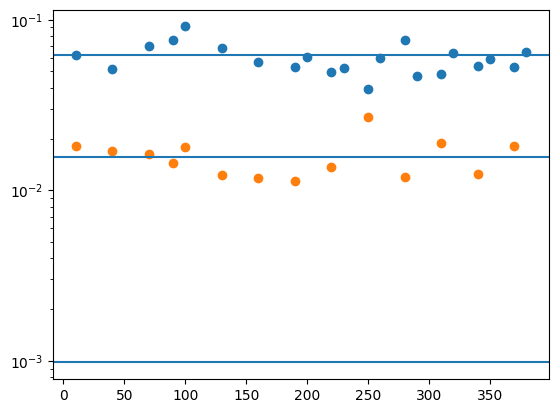

In [154]:
exp.plot_results(bp=True)
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-10)

plt.yscale('log')

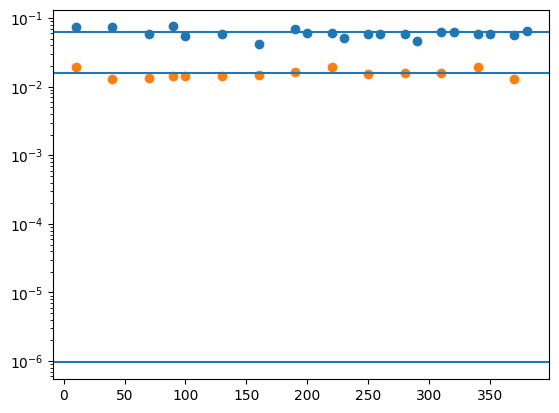

In [147]:
exp.plot_results(bp=True)
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-20)

plt.yscale('log')

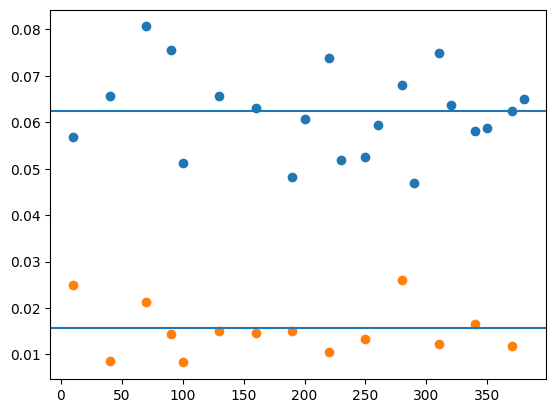

In [141]:
exp.plot_results(bp=True)
plt.axhline(2**-4)
plt.axhline(2**-6)

In [127]:
v = exp.barren_results[6][90]['vals']
np.array(v).mean(axis=1)

array([-2.13284583e-02, -8.00309833e-17,  2.17972156e-02])

In [128]:
v = exp.barren_results[6][100]['vals']
np.array(v).mean(axis=1)

array([-2.08742537e-17, -2.18440913e-02, -2.33441148e-02])

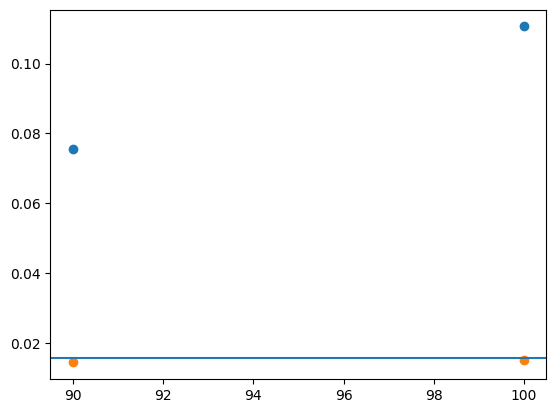

In [129]:
exp.plot_results(bp=True)
plt.axhline(2**-6)

In [83]:
np.random.seed(1)
exp.run_barren_plateau_experiment(6, range(10, 200, 30), num_obs=1, num_samples = 10 * 2**6)

  0%|          | 0/7 [00:00<?, ?it/s]

phi
[1.57079633 4.71238898 0.         0.         4.71238898 1.57079633
 4.71238898 1.57079633 4.71238898 0.         0.         1.57079633
 0.         4.71238898 1.57079633 0.         3.14159265 1.57079633
 3.14159265 0.         3.14159265 1.57079633 3.14159265 0.
 4.71238898 0.         3.14159265 0.         1.57079633 3.14159265
 3.14159265 0.         4.71238898 4.71238898 1.57079633 1.57079633
 4.71238898 3.14159265 0.         3.14159265 1.57079633 1.57079633
 1.57079633 4.71238898 4.71238898 1.57079633 3.14159265 1.57079633
 1.57079633 0.         0.         1.57079633 0.         0.
 1.57079633 4.71238898 4.71238898 3.14159265 1.57079633 0.
 3.14159265 4.71238898 4.71238898 3.14159265 1.57079633 1.57079633
 1.57079633 4.71238898 0.         0.         1.57079633 4.71238898
 0.         3.14159265 0.         0.         1.57079633 4.71238898
 1.57079633 3.14159265 4.71238898 0.         0.         1.57079633
 4.71238898 3.14159265 4.71238898 4.71238898 3.14159265 1.57079633
 0.         3.1

/tmp/ipykernel_8385/276277946.py:65: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/276277946.py:66: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


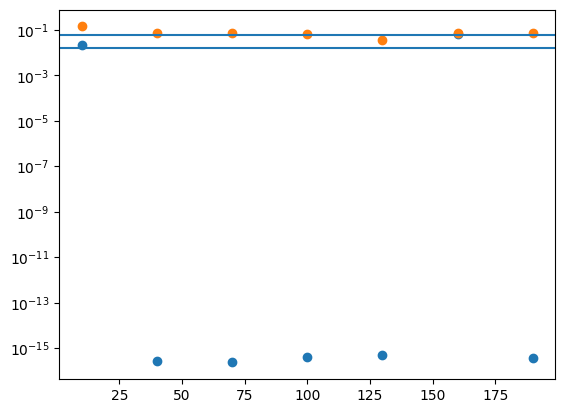

In [79]:
exp.plot_results(bp=True)
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.yscale('log')

In [25]:

exp.run(6, range(400, 600, 30), num_obs=20)

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_8385/3041042337.py:39: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/3041042337.py:40: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


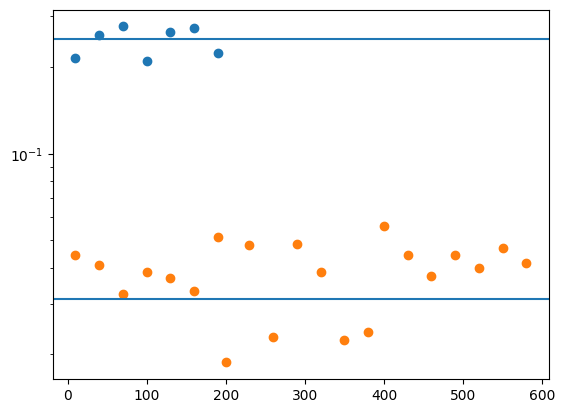

In [26]:
exp.plot_results()
plt.axhline(2**-2)
plt.axhline(2**-5)
plt.yscale('log')

/tmp/ipykernel_8385/3041042337.py:39: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/3041042337.py:40: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


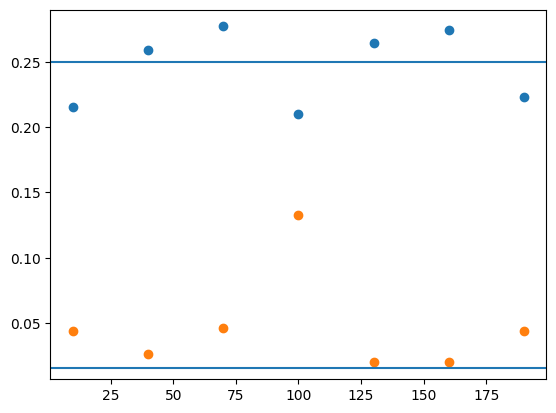

  0%|          | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_8385/3041042337.py:39: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/3041042337.py:40: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


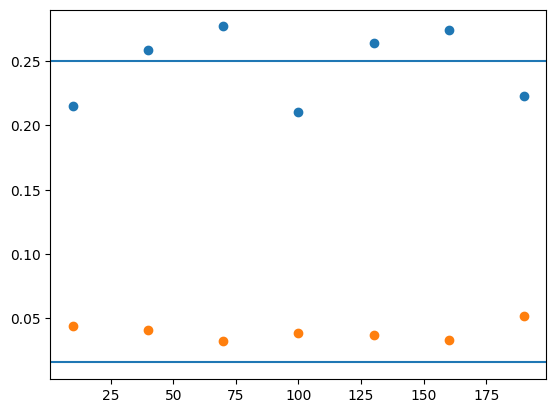

In [20]:
np.random.seed(0)
exp.run(6, range(10, 200, 30), num_obs=20)

/tmp/ipykernel_8385/3041042337.py:39: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/3041042337.py:40: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


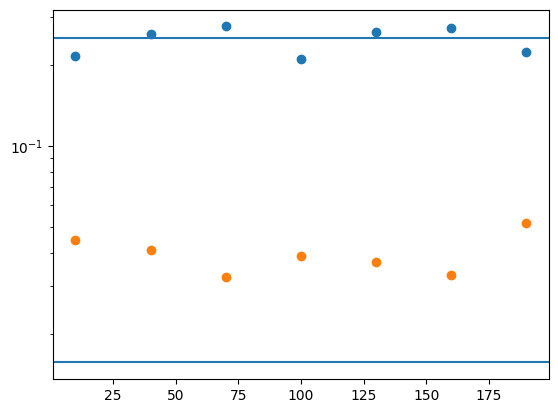

In [21]:
exp.plot_results()
plt.axhline(2**-2)
# plt.axhline(2**-4)
plt.axhline(2**-6)
# plt.axhline(2**-8)
plt.yscale('log')

/tmp/ipykernel_8385/3740760894.py:40: RuntimeWarning: Mean of empty slice.
  grad_means = [np.abs(expvals[n][layer]['grads']).mean() for layer in layers]
/tmp/ipykernel_8385/3740760894.py:41: RuntimeWarning: Mean of empty slice.
  hess_means = [np.abs(expvals[n][layer]['hess']).mean() for layer in layers]


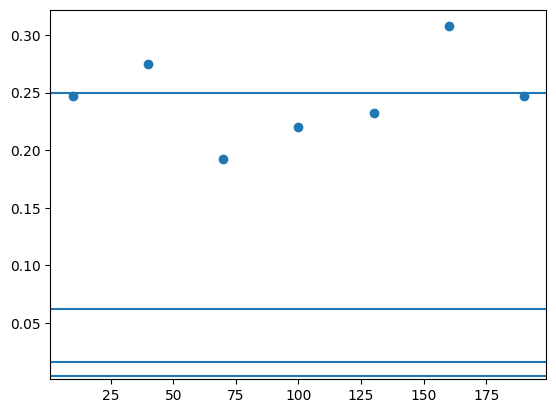

In [11]:
exp.plot_results()
plt.axhline(2**-2)
plt.axhline(2**-4)
plt.axhline(2**-6)
plt.axhline(2**-8)


In [64]:
np.random.binomial(5, 0.1, size=10)

array([1, 2, 0, 0, 0, 2, 1, 2, 1, 0])

In [40]:
help(np.random.binomial)

Help on built-in function binomial:

binomial(...) method of numpy.random.mtrand.RandomState instance
    binomial(n, p, size=None)
    
    Draw samples from a binomial distribution.
    
    Samples are drawn from a binomial distribution with specified
    parameters, n trials and p probability of success where
    n an integer >= 0 and p is in the interval [0,1]. (n may be
    input as a float, but it is truncated to an integer in use)
    
    .. note::
        New code should use the `~numpy.random.Generator.binomial`
        method of a `~numpy.random.Generator` instance instead;
        please see the :ref:`random-quick-start`.
    
    Parameters
    ----------
    n : int or array_like of ints
        Parameter of the distribution, >= 0. Floats are also accepted,
        but they will be truncated to integers.
    p : float or array_like of floats
        Parameter of the distribution, >= 0 and <=1.
    size : int or tuple of ints, optional
        Output shape.  If the given 

n 2 s 16
n 4 s 64
n 6 s 256
n 8 s 1024


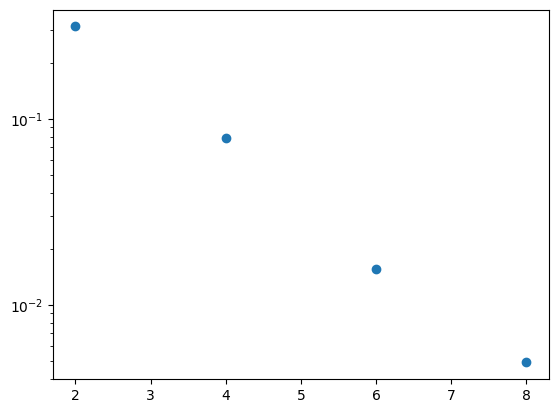

In [72]:
epsilon = 0.5
ns = range(2, 10, 2)

vals = []
for n in ns:
    p = 2**-n
    s = int(1/p/epsilon**2)
    print('n',n, 's', s)
    vals.append(np.random.binomial(1, p, size=s).mean())
    
plt.scatter(ns, vals)
plt.yscale('log')

In [41]:
num_qubits = 2
layers = range(200, 300, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

In [42]:
num_qubits = 4
layers = range(200, 300, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

In [43]:
num_qubits = 6
layers = range(200, 300, 20)
num_obs = 10
num_samples = 100

run_experiment(num_qubits, layers, num_obs, num_samples)

  0%|          | 0/5 [00:00<?, ?it/s]

defaultdict(dict,
            {2: {1: {'vals': array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.99999976,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.99999976,  0.        ,  0.        ,  0.99999976,  0.99999976],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        , -0.9999999 ,  0.        ,
                       -0.9999999 ,  0.        , -0.9999999 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.99999976,
                        0.        ,  0.        ,  0.9999998 ,  0.        ,  0.        ],
                      [ 0.        ,  0.        ,  0.        ,  0.        ,  0.     

In [48]:
import pickle

with open('expvals', 'wb') as f:
    pickle.dump(expvals, f)

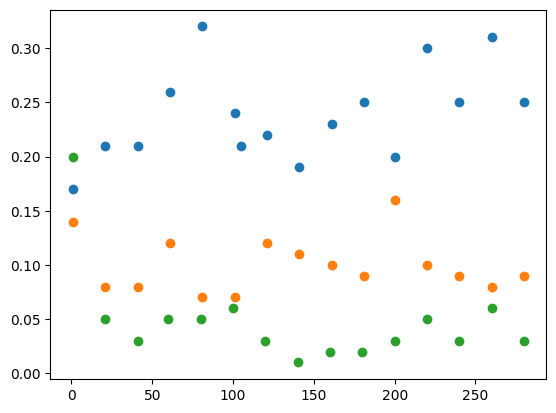

In [44]:
plot_results()